# Coding Task

## Table of Contents
- Generating the Dataset
    - Generating the demographic information
    - Generating the attitudes towards vaccination
    - Generating the underlying social network
    - Generating the treatment status
    - Generating the outcome variable
- Conducting the Analysis

### Importing Needed libraries
This notebook assumes that the working directory is the root of the project folder. Otherwise, change the directory using `os.chdir()`.

In [34]:
# Importing libraries
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('ggplot')
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, manhattan_distances
from sklearn.cluster import KMeans, SpectralClustering

import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LogisticRegression

# Set random seed for reproducibility
np.random.seed(111)

In [35]:
# UTILS: generate n random numbers that add to one
def generate_weights(n,scaling=None): 
    w = np.random.uniform(0,1,n)
    if scaling is not None:
        w = w * scaling
    return w/np.sum(w)

### Generating Demographic Information

In [36]:
# Initialize an empty dataframe with 5000 rows
n = 5000 # number of samples to generate
demographics_df = pd.DataFrame(index=range(n))

# Generate demographic data
demographics_df['demographic_age'] = np.round(np.random.uniform(21,80,n)).astype('int')
demographics_df['demographic_income'] = (1 - np.random.power(2.5,n)) * 5000000
demographics_df['demographic_education'] = np.round(np.random.uniform(0,5,n)).astype('int')
demographics_df['demographic_unobs_grp'] = np.random.choice(['A','B','C','D','E'],n)

demographic_cont_vars = ['demographic_age','demographic_income','demographic_education']
demographic_cat_vars = 'demographic_unobs_grp'

### Generating Attitudes Towards Vaccination

In [37]:
def generate_attitudes(df):
    # Normalize continuous variables
    this_df = df.copy(deep=True)
    this_df[demographic_cont_vars] = this_df[demographic_cont_vars]/this_df[demographic_cont_vars].std()
    this_df[demographic_cont_vars] = this_df[demographic_cont_vars]/this_df[demographic_cont_vars].max()

    # Dummy categorical variables
    this_df = pd.get_dummies(this_df,columns=[demographic_cat_vars],drop_first=False)

    # Normalize variables by z-score
    this_df = this_df/this_df.std()

    # Generate attitudes
    attitudes = ['att_covid','att_vaccine','att_safety','att_unobserved']
    attitudes_df = pd.DataFrame(index=range(n))
    demographics = list(this_df.columns)

    for attitude in attitudes:
        attitudes_df[attitude] = np.random.uniform(1,5,n) + np.random.normal(0,0.25,n) # Intrinsic views plus random error
        demographic_weights = generate_weights(len(demographics),scaling=[1,1,1,1/4,1/4,1/4,1/4,1/4]) # Generate weight of each demographic's effect
        for i,demographic in enumerate(demographics): # Add influence of demographics
            attitudes_df[attitude] = attitudes_df[attitude] + demographic_weights[i] * this_df[demographic]

        # Handle values that are outside of max range (1-10)
        attitudes_df[attitude] = attitudes_df[attitude].clip(1,10)

        # Round
        attitudes_df[attitude] = np.round(attitudes_df[attitude]).astype('int')
    return attitudes_df

attitudes_df = generate_attitudes(demographics_df)
print(demographics_df.shape)
attitudes_df.head(1)

(5000, 4)


,att_covid,att_vaccine,att_safety,att_unobserved
0,3,6,4,6


### Generating Network Structure

In [38]:
class diffusion_network:
    """
    This class will generate a network based on a population's demographic information or an existing edgelist.
    Arguments:
    ===========
    demographics_df: pd.Dataframe
        Denotes the demographic attributes to generate a dataframe on. Can have as many columns as needed
    edgelist: pd.Dataframe
        A two-column dataframe denoting the network edgelist
    num_nodes: int
        How many nodes that network generated from demographics should have. Must be equal to the number of rows in demographics_df.
    edges_per_node: int
        How many edges each node should have when it enters the network.
    n_communities: int
        The number of communities in the network.
    community_strength: int
        Denotes the increased likelihood of a node connecting to an in-community node relative to out-community node.
        For example, community_strength=100 denotes that every node is 100x more likely to connect to a node in its same community compared to a node not in its community.

    """
    def __init__(self, demographics_df=None,edgelist=None,num_nodes:int=5000,n_communities:int=100,community_strength:int=99999):
        # Save the basic network attributes of the network
        self.num_nodes = num_nodes
        self.n_communities = n_communities
        self.community_strength = community_strength
        self.delta = []


        # Initialize the network structure either from an edgelist or a population's demographic information
        if demographics_df is None and edgelist is None: 
            raise Exception("Specify how the network should be generated")
        elif demographics_df is not None and edgelist is not None:
            raise Exception("Please only input demographic information or and edgelist, not both.")
        elif demographics_df is not None:
            self.G = self.generate_network_from_demographic(demographics_df,num_nodes,n_communities,community_strength)
        elif edgelist is not None:
            self.G = self.import_edgelist(edgelist)

        """Initialize the node attributes for diffusion"""
        # Generate and validate network adjacency matrix
        self.adj_matrix = nx.to_numpy_array(self.G)
        assert self.adj_matrix.shape[0] == self.adj_matrix.shape[1]

        # Normalize adjacency matrix to get the mean influence weight of each node
        row_sums = self.adj_matrix.sum(axis=1, keepdims=True)
        self.normalized_adj_matrix = self.adj_matrix / row_sums
        
        # Check that the network structure has an eventual stable state (i.e. all eigenvalues >= 1 are not complex numbers)
        self.eigvals, self.eigvecs = np.linalg.eig(self.normalized_adj_matrix) 
        self.signf_eigvals = np.abs(self.eigvals) > 0.999
        isreal_eigvals = np.isreal(self.eigvals)
        if not np.array_equal(np.logical_and(self.signf_eigvals,isreal_eigvals), self.signf_eigvals):
            raise Exception("This network has no stable state. Please regenerate the network.")
        


    def generate_network_from_demographic(self,attitudes_df:pd.DataFrame,num_nodes,n_communities,community_strength,diagnostic_plots=True):
        """Generate a Bianconi-Barabási model with Homophily"""
        # Create communities based on vaccination attitudes
        cluster_model = KMeans(n_clusters=n_communities, random_state=100)
        cluster_model.fit(attitudes_df)
        community = cluster_model.labels_

        # Save community assignments to a table for later use
        self.node_community = pd.Series(community)
        self.node_community.index.name = 'id'
        self.node_community.name = 'community'

        # Generate similarity matrix based on if nodes are in same community
        demographic_similarity = np.ones((len(community),len(community)))
        for i in range(0,len(community)):
            for j in range(0,len(community)):
                if community[i] == community[j]:
                    demographic_similarity[i,j] = community_strength # increased likelihood of an edge if in same community
        
        # Map community to a list of node numbers
        community = pd.DataFrame(community,columns=['community']).reset_index()
        comm_to_node = community.groupby('community')['index'].agg(list).to_dict()
    
        def bb_network(N, m,demographic_similarity): # Generate a Bianconi–Barabási (BB) network
            # 1. Start with undirected graph
            G = nx.Graph()

            # 2. Create a fully-connected clique (of size m + 1) for each community
            for community in comm_to_node:
                G.add_nodes_from(comm_to_node[community][:(m+1)])
                G.add_edges_from(list(itertools.combinations(comm_to_node[community][:(m + 1)], 2)))

            connected_nodes = G.number_of_nodes()
            i = m
            while connected_nodes < N:
                i += 1
                for community in comm_to_node: # 3. add one node from a community then move on to next community
                    if i < len(comm_to_node[community]):
                        connected_nodes += 1
                        node_to_add = comm_to_node[community][i]

                        # 4. Connect the new node to m different nodes, weighted by their similarity and number of existing ties.
                        possible_neighbors = list(G.nodes)
                        G.add_node(node_to_add)

                        weight = [demographic_similarity[node_to_add,j] * G.degree(j) for j in possible_neighbors]
                        p = np.array(weight)/np.sum(np.array(weight))
                        new_neighbors = np.random.choice(possible_neighbors, size=m, replace=False, p=p)

                        for j in new_neighbors:
                            G.add_edge(node_to_add, j)
            return G
        
        # Calculate number of edges per node in BB network to achieve a low in-group density
        density = 0.2
        community_size = num_nodes/n_communities
        edges_per_node = np.round(density * (community_size - 1) * 0.5).astype('int')
        
        G = bb_network(num_nodes,3,demographic_similarity) # Generate BB network

        # Print Network Diagnostic Information:
        print('\033[92m Network Generation Successful')
        print('\033[92m Number of Nodes:',G.number_of_nodes())
        print("\033[92m Number of Edges:",G.number_of_edges())
        print("\033[92m Average Clustering:",nx.average_clustering(G))
        print("\033[92m Modularity:",nx.community.modularity(G,comm_to_node.values()))

        if diagnostic_plots: # Plot Network Degree Distribution
            degree_dist = list(dict(G.degree).values())
            generate_log_bin = lambda data: np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), 20)
            plt.hist(degree_dist,bins=generate_log_bin(degree_dist))
            plt.title('Degree distribution of network')
            plt.xlabel('Degree centrality')
            plt.ylabel('Frequency')
            plt.xscale('log')
            plt.yscale('log')
            plt.show()
        return G

    """Implement Importing Functions to Import and Export to Nodelist"""
    def import_edgelist(self,edgelist:pd.DataFrame):
        return nx.from_pandas_edgelist(edgelist)
    
    def export_edgelist(self,filename:str='edgelist.csv'):
        edgelist = nx.to_pandas_edgelist(self.G)
        edgelist.columns = ['source', 'target']
        edgelist.to_csv(filename,index=False)
        return None


    """Implement Diffusion of Ideas Along Network"""
    def run_diffusion_many_rounds(self,node_values,recursion_depth=0): # Run diffusion until the opinion change each round if too small to shift someone's opinion by even 5 point
        new_node_values = np.dot(self.normalized_adj_matrix,node_values)
        delta = new_node_values - node_values

        recursion_depth += 1
        self.delta.append(np.sum(np.abs(delta)))

        if recursion_depth >= 100: # Return results if
            return np.round(new_node_values).astype('int')
        else: # Call itself again if the network is still changing
            return self.run_diffusion_round(new_node_values,recursion_depth)
        
    def run_diffusion_round(self,node_values,recursion_depth=0,target_delta=0.1): # Run diffusion until the average opinion change each round is too small

        new_node_values = np.dot(self.normalized_adj_matrix,node_values)
        delta = np.mean(np.abs(new_node_values - node_values))

        recursion_depth += 1
        self.delta.append(delta)

        if delta <= target_delta or recursion_depth > 500: # Return results if change in network sufficiently small
            return np.round(new_node_values).astype('int')
        else: # Call itself again if the network is still changing
            return self.run_diffusion_round(new_node_values,recursion_depth)
        
    def fj_diffusion(self,node_values):
        L = nx.laplacian_matrix(self.G)
        I = np.identity(L.shape[0])
        A = np.linalg.inv(I + L)

        return np.round(np.dot(A,node_values))


 Network Generation Successful
 Number of Nodes: 5000
 Number of Edges: 14400
 Average Clustering: 0.24894563634714387
 Modularity: 0.987721096161265


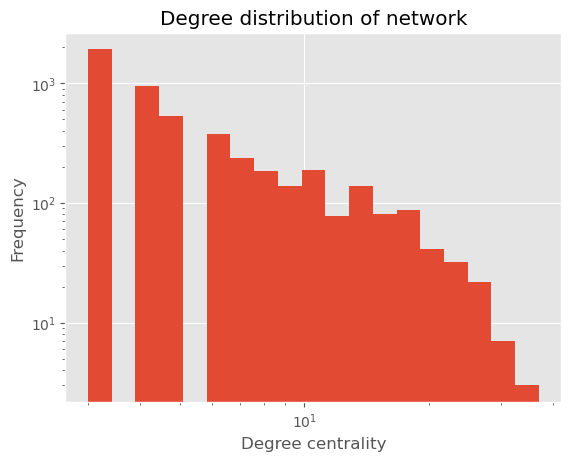

In [39]:
this_network = diffusion_network(attitudes_df)

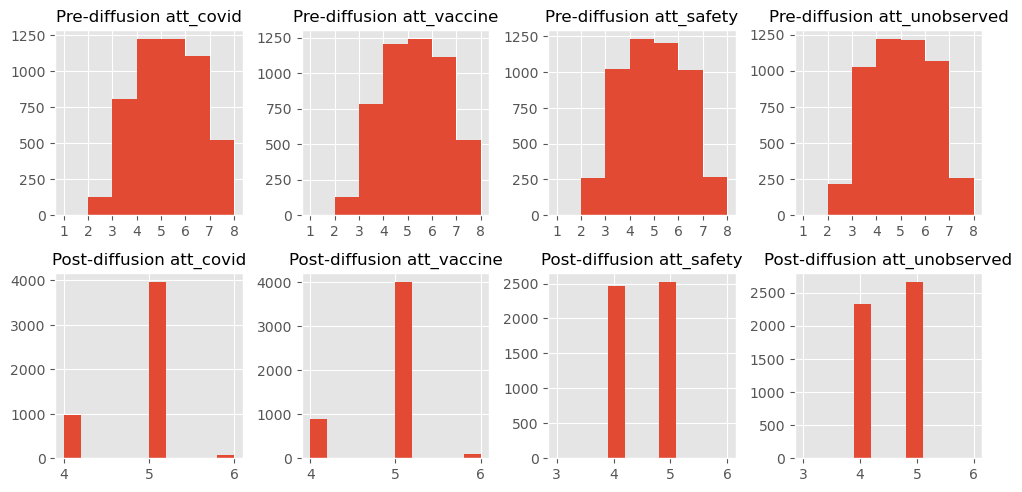

In [40]:
fig, ax = plt.subplots(nrows=2,ncols=4,squeeze=False,figsize=(10,5))
for i, attitude in enumerate(attitudes_df.columns):

    # Plot distribution of pre diffusion values
    ax[0,i].hist(attitudes_df[attitude],bins = range(1,9))
    ax[0,i].set_title('Pre-diffusion ' + str(attitude),fontsize=12)
    ax[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot distribution of post diffusion values
    attitudes_df[attitude] = this_network.fj_diffusion(attitudes_df[attitude])
    ax[1,i].hist(attitudes_df[attitude])
    ax[1,i].set_title('Post-diffusion ' + str(attitude),fontsize=12)
    ax[1,i].xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout(pad=1.0)
plt.show()

Export edgelist and nodelist to csv for Gephi

In [41]:
this_network.export_edgelist(filename='figures/gephi/edgelist.csv')
nodelist = attitudes_df['att_safety']
nodelist.index.name = 'id'
nodelist.to_csv('figures/gephi/nodelist.csv')

Export network edgelist

In [42]:
this_network.export_edgelist(filename='data/edgelist.csv')

Export pre-treatment survey to csv

In [43]:
pre_treatment_df = pd.merge(attitudes_df,demographics_df,how='inner',left_index=True,right_index=True)
pre_treatment_df = pre_treatment_df.drop(columns=['att_unobserved','demographic_unobs_grp']) # Drop unobserved colummns
pre_treatment_df.head(1)

,att_covid,att_vaccine,att_safety,demographic_age,demographic_income,demographic_education
id,,,,,,
0,5.0,5.0,5.0,57,1.527737e+06,4


In [44]:
pre_treatment_df.to_csv('data/pre_treatment.csv')

## Model Treatment Effects

In [45]:
treatment_assignment_df = this_network.node_community.copy(deep=True).to_frame()

# Assign treatments to each group randomly with equal probability
community_to_treatment = np.random.choice([None,'reason','emotion'],size=this_network.n_communities) 
treatment_assignment_df['treatment'] = community_to_treatment[treatment_assignment_df['community']]

treatment_assignment_df = pd.get_dummies(treatment_assignment_df,columns=['treatment'])
treatment_assignment_df.to_csv('data/treatment_assignment.csv') # Save to file
treatment_assignment_df.head(1)

,community,treatment_emotion,treatment_reason
id,,,
0,29,False,True


Model effects of treatment on attitudes

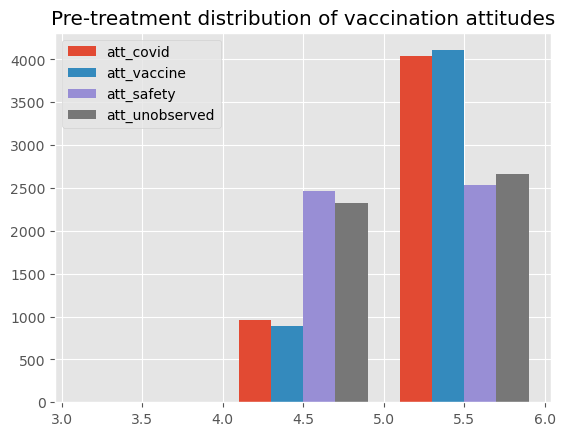

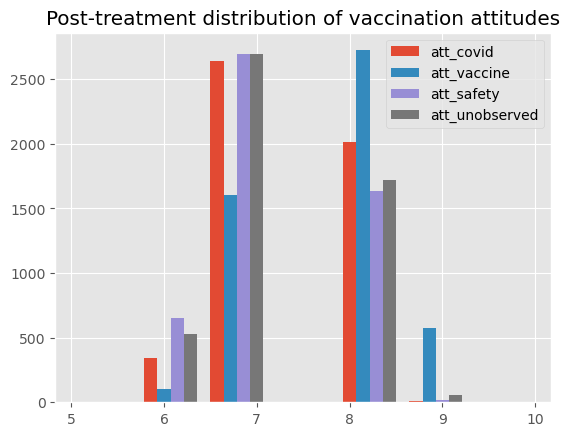

In [46]:
def apply_treatment(treatment_assignment_df,attitudes_df,demographics_df):
    attitudes_df = attitudes_df.copy(deep=True)

    # Preprocess demographics_df
    demographics_df = pd.get_dummies(demographics_df,columns=['demographic_unobs_grp'],drop_first=False) # Dummy a variable
    demographics_df = demographics_df/demographics_df.std() # Normalize demographic values by standard deviation

    # Calculate treatment effect for each attitude
    for attitude in attitudes_df.columns:
        att_values = (treatment_assignment_df['treatment_emotion'] | treatment_assignment_df['treatment_reason']).astype('int') * 3 # add base treatment effect
        att_values = att_values + np.random.normal(0,0.2,5000) # add random error term
        for demographic in demographics_df.columns:

            # Calculate heterogenous treatment effect for units given emotion treatment
            att_values = att_values + np.random.uniform(0,0.25) * treatment_assignment_df['treatment_emotion'] * demographics_df[demographic]

            # Calculate heterogenous treatment effect for units given reason treatment
            att_values = att_values + np.random.uniform(0,0.25) * treatment_assignment_df['treatment_emotion'] * demographics_df[demographic]

        attitudes_df[attitude] = attitudes_df[attitude] + att_values
        # Run network diffusion
        attitudes_df[attitude] = this_network.fj_diffusion(attitudes_df[attitude])
    
    # Round and Truncate Values
    attitudes_df = np.round(attitudes_df).astype('int')
    attitudes_df = attitudes_df.clip(1,10)
    return attitudes_df

# Plot pre-treatment attitudes
plt.title('Pre-treatment distribution of vaccination attitudes')
plt.hist(attitudes_df,bins=3)
plt.legend(attitudes_df.columns)
plt.show()

# Calculate and plot post-treatment attitudes
attitudes_df = apply_treatment(treatment_assignment_df,attitudes_df,demographics_df)
plt.title('Post-treatment distribution of vaccination attitudes')
plt.hist(attitudes_df,bins=7)
plt.legend(attitudes_df.columns)
plt.show()

## Model propensity to vaccinate

In [47]:
# Probability of vaccinating
weights = generate_weights(4)
vaccine_prob = np.zeros_like(attitudes_df.iloc[:,1])
for i,attitude in enumerate(attitudes_df.columns): # Weighted mean of each attitude
    vaccine_prob += attitudes_df[attitude] * weights[i]
vaccine_prob = vaccine_prob/10 # Normalize 10-point attitude scale into probability 
vaccine_prob = vaccine_prob + np.random.normal(0,0.1) # Add random error

# Convert vaccine probability into vaccination outcome
post_survey = attitudes_df.copy(deep=True)
post_survey['vaccine'] = (vaccine_prob > np.random.uniform(0,1,5000))
post_survey.head(1)

,att_covid,att_vaccine,att_safety,att_unobserved,vaccine
id,,,,,
0,8,8,8,8,False


Save post-treatment survey

Drop random rows to simulate 500 entries with attrition

In [48]:
# Mask 500 random entries
rows_to_drop = np.random.choice(range(0,5000),500,replace=False)
post_survey = post_survey.astype('int').astype('float')
post_survey.loc[rows_to_drop,:] = np.nan

# Drop unobserved variable
post_survey = post_survey.drop(columns=['att_unobserved'])

post_survey.head(1)

,att_covid,att_vaccine,att_safety,vaccine
id,,,,
0,8.0,8.0,8.0,0.0


In [49]:
post_survey.to_csv('data/post_treatment.csv')

## Post-Simulation Analysis 

Clear data cache and re-import packages

In [50]:

# Clear memory


Combining the dataframes

In [51]:
pre_treatment_df = pd.read_csv('data/pre_treatment.csv',index_col='id')
random_assignment_df = pd.read_csv('data/treatment_assignment.csv',index_col='id')
post_treatment_df = pd.read_csv('data/post_treatment.csv',index_col='id')

# Rename variables to indicate if they're from pre or post_treatment
pre_treatment_df.columns = ['pre_' + x for x in pre_treatment_df.columns]
post_treatment_df.columns = ['post_' + x for x in post_treatment_df.columns]

# Merge all dataframes together
merged_df = pre_treatment_df.merge(random_assignment_df,left_index=True,right_index=True,how='inner',validate='1:1')
merged_df = merged_df.merge(post_treatment_df,how='inner',left_index=True,right_index=True,validate='1:1')
merged_df.head(50)

# Drop attritioned entries
merged_df = merged_df.dropna()

merged_df.head(1)

,pre_att_covid,pre_att_vaccine,pre_att_safety,pre_demographic_age,pre_demographic_income,pre_demographic_education,community,treatment_emotion,treatment_reason,post_att_covid,post_att_vaccine,post_att_safety,post_vaccine
id,,,,,,,,,,,,,
0,5.0,5.0,5.0,57,1.527737e+06,4,29,False,True,8.0,8.0,8.0,0.0


**Description of Population**

In [52]:
# Defining a few sets of variables
base_att = ['att_covid','att_safety','att_vaccine']
pre_att = ['pre_att_covid','pre_att_safety','pre_att_vaccine']
post_att = ['post_att_covid','post_att_safety','post_att_vaccine']
demographics = ['pre_demographic_age', 'pre_demographic_income', 'pre_demographic_education']
treatments = ['treatment_emotion','treatment_reason']
outcome = 'post_vaccine'

**Basic regression table**

Analyzing the experiment's treatment effects on an individual-level suggests that the treatments **do not** have a statistically significant effect on increasing vaccine uptake.

In [53]:

regressions = [treatments,demographics + treatments,pre_att + demographics + treatments]
reg_outcomes = []

for regression in regressions:
    X = sm.add_constant(merged_df[regression]).astype('float')
    Y = merged_df[outcome].astype('float')
    reg_outcomes.append(sm.OLS(Y,X).fit())

reg_table = Stargazer(reg_outcomes)
reg_table

This null effect is also reflected in the attitudes about vaccination (which is highly correlated with propensity to vaccinate). Network interference has made the opinion distribution of the control group identical to that of the treatment groups.

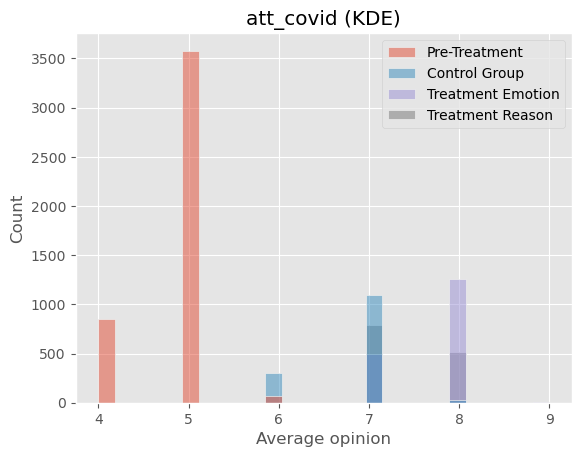

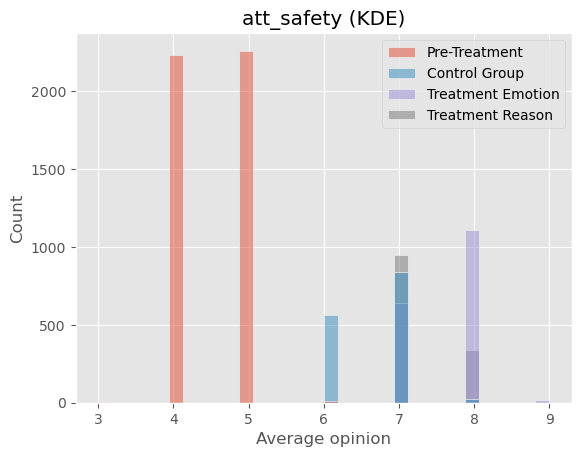

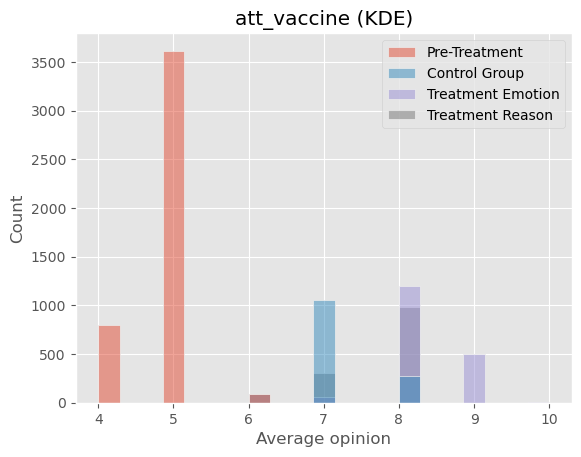

In [54]:
for att in base_att:
    sns.histplot(data=[merged_df['pre_'+att].rename('Pre-Treatment'),
        merged_df[~(merged_df['treatment_reason'].astype('bool') | merged_df['treatment_emotion'].astype('bool'))]['post_'+att].rename('Control Group'),
        merged_df[merged_df['treatment_emotion'].astype('bool')]['post_'+att].rename('Treatment Emotion'),
        merged_df[merged_df['treatment_reason'].astype('bool')]['post_'+att].rename('Treatment Reason')])
    plt.xlabel('Average opinion')
    plt.title(att + ' (KDE)')
    plt.show()

**Taking into account the network structure**

If we could observe the underlying network structure, we would realize that vaccination-rate is highly correlated with the community that the individual is part of.

In [55]:
# Create a predicted probability of vaccination based on post-attitudes. Train model:
Y = merged_df['post_vaccine']
X = merged_df[post_att]
reg = LogisticRegression().fit(X, Y)

# Predict probability of vaccination
merged_df['post_vaccine_proba'] = reg.predict_proba(X)[:,1]

# Rank transform the probabilities to highlight contrast
merged_df['post_vaccine_proba'] = merged_df['post_vaccine_proba'].rank()

In [56]:
# Export vaccination information to Gephi for visualization
vaccine_nodelist = merged_df['post_vaccine_proba'].to_csv('figures/gephi/vaccine_nodelist.csv')

Gephi visualization:

![Gephi graph legend](figures/gephi/vaccine_propensity_legend.png)


![Gephi graph showing within-community heterogeneity](figures/gephi/vaccine_propensity.png)

Thus could get a much more accurate treatment effect point estimate.

In [57]:
# Detect the communites
network = nx.from_pandas_edgelist(pd.read_csv('data/edgelist.csv'))
communities = nx.community.greedy_modularity_communities(network, resolution=10)

modularity = {}
avg_density = {}
avg_betweeness = {}
# Calculate modularity of each 
def single_community_modularity(G, community):
    m = G.size(weight=None)  # total number of edges
    degrees = dict(G.degree())
    Q = 0.0
    for u in community:
        for v in community:
            A = 1 if G.has_edge(u, v) else 0
            Q += A - (degrees[u] * degrees[v]) / (2 * m)
    return Q / (2 * m)

for community in range(0,len(communities)):
    modularity[community] = single_community_modularity(network,communities[community])

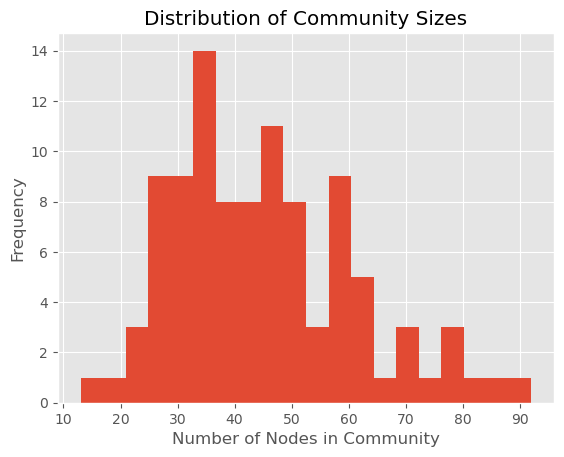

In [58]:
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i
community_map = pd.Series(community_map)
merged_df['community'] = community_map
merged_df['community'] = merged_df['community'].astype('category')

# Plot community size
plt.hist(np.unique(merged_df['community'],return_counts=True)[1],bins=20)
plt.title('Distribution of Community Sizes')
plt.xlabel('Number of Nodes in Community')
plt.ylabel('Frequency')
plt.show()

In [59]:
merged_df=merged_df.groupby('community').mean()

merged_df['modularity'] = pd.Series(modularity)# Insert community modularity
print(merged_df.shape)
merged_df.head(1)

(100, 14)


C:\Users\bings\AppData\Local\Temp\ipykernel_15316\1341084391.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df=merged_df.groupby('community').mean()


,pre_att_covid,pre_att_vaccine,pre_att_safety,pre_demographic_age,pre_demographic_income,pre_demographic_education,treatment_emotion,treatment_reason,post_att_covid,post_att_vaccine,post_att_safety,post_vaccine,post_vaccine_proba,modularity
community,,,,,,,,,,,,,,
0,4.923913,4.956522,4.684783,54.282609,1.594880e+06,2.836957,0.0,1.0,7.423913,7.804348,7.26087,0.673913,2387.315217,0.0198


In [60]:
reg_outcomes = []
outcome_vars = post_att + ['post_vaccine',]
for att in outcome_vars:
    X = sm.add_constant(merged_df[treatments + pre_att]).astype('float')
    Y = merged_df[att].astype('float')
    reg_outcomes.append(sm.OLS(Y,X).fit())

reg_table = Stargazer(reg_outcomes)
reg_table.custom_columns(outcome_vars)
reg_table

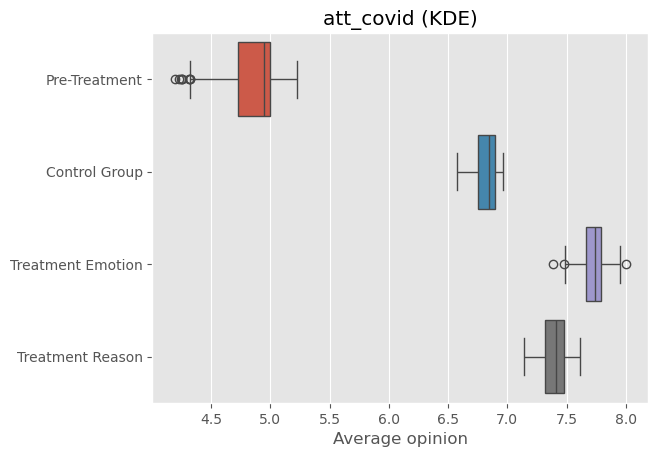

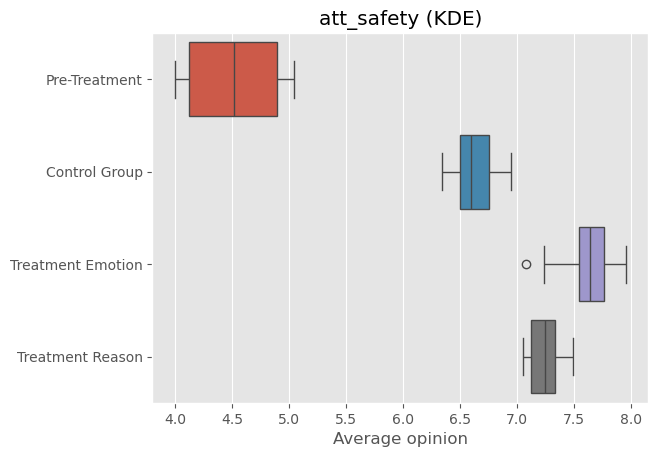

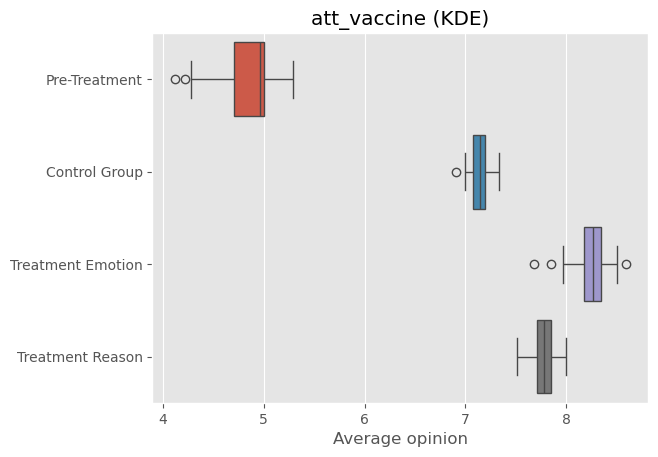

In [61]:
for att in base_att:
    sns.boxplot(data=[merged_df['pre_'+att].rename('Pre-Treatment'),
                 merged_df[~(merged_df['treatment_reason'].astype('bool') | merged_df['treatment_emotion'].astype('bool'))]['post_'+att].rename('Control Group'),
                 merged_df[merged_df['treatment_emotion'].astype('bool')]['post_'+att].rename('Treatment Emotion'),
                 merged_df[merged_df['treatment_reason'].astype('bool')]['post_'+att].rename('Treatment Reason')],
                 orient='h')
    plt.xlabel('Average opinion')
    plt.title(att + ' (KDE)')
    plt.show()

In [62]:
merged_df['modularity * treatment_emotion'] = merged_df['modularity'] * merged_df['treatment_emotion']
merged_df['modularity * treatment_reason'] = merged_df['modularity'] * merged_df['treatment_reason']

modularity = ['modularity','modularity * treatment_emotion','modularity * treatment_reason']

reg_outcomes = []
outcome_vars = post_att + ['post_vaccine',]
for att in outcome_vars:
    X = sm.add_constant(merged_df[modularity+treatments]).astype('float')
    Y = merged_df[att].astype('float')
    reg_outcomes.append(sm.OLS(Y,X).fit())

reg_table = Stargazer(reg_outcomes)
reg_table.custom_columns(outcome_vars)
reg_table